In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cvxpy as cp
import seaborn as sns
from abc import ABC, abstractmethod

import os
from multiprocessing import Pool
import datetime
from utils import *
from viz import *
from decision_functions import *
from metrics import *
import glob

%matplotlib inline

In [2]:
## NOTE: THIS NOTEBOOK ASSUMES GUROBI IS INSTALLED.
save = True  ## sample results are saved to files and re-read when averaging

USE_METHODS = {
    "Argmax",
    "Thompson Sampling",
    "Aggregate Posterior Matching",
    "Threshold",
    "Integer Program",
    "Top-k Sampling",
}

# Data Generation

In [3]:
class YDist:
    """
    labels are {0, ..., n_classes}.
    samples are represented in dense form, unless otherwise specified.
    """

    def __init__(self, prior, random_seed=None) -> None:
        self.n_classes = len(prior)
        self.prior = np.array(prior)
        self.random = np.random.default_rng(seed=random_seed)

    def sample(self, n_samples, inflate=False):
        labels = self.random.multinomial(n_samples, self.prior).astype(int)
        if inflate:
            labels = np.repeat(np.arange(len(self.prior)), labels)
        return labels

    def expected_marginal(self, n_samples):
        return exact_counts(self.prior, n_samples)
        # pass


class XDist(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def atomic_x_generator(self, y_val, n):
        pass

    @abstractmethod
    def bayes_posterior(self, X):
        pass

    def generate_x(self, y_sample):
        """
        Args:
            label_counts (list[int]): n_classes length list of the number of times each class appears
            feature dist (ndarray): n_classes x n_categories ndarray of x|y probabilities, for categorical feature of finite values
        """
        x_data = [
            self.atomic_x_generator(val, n) for val, n in enumerate(y_sample)
        ]  ## all x_data samples must be (n_subsample, n_classes)
        # # n_features is arbitrary
        x_data = np.concatenate(x_data)
        return x_data

    def sample_mae(self, sample_bayesian_posterior, sample_px):
        """
        calculates the mae on a sample
        sample_prob is (n_samples), being p(x) for each sampled x
        sample_bayesian_posterior is (n_samples, n_classes), being p(y|x) for each sampled x
        """
        abs_errors = 1 - sample_bayesian_posterior  ## n_samples, n_classes
        weighted_errors = np.sum(
            abs_errors * sample_bayesian_posterior, axis=1
        )  ## n_samples
        estimated_px = sample_px / np.sum(
            sample_px
        )  # normalize to 1; this serves as a sample of p(x)

        mae = estimated_px @ weighted_errors
        return mae


class CategoricalXDist(XDist):
    def __init__(self, y_dist: YDist, px_given_y, random_seed=None) -> None:
        self.y_dist = y_dist
        self.px_given_y = px_given_y  ## (n_classes, n_categories)
        self.random = np.random.default_rng(seed=random_seed)
        self.expected_posteriors = (
            self._categorical_bayes_optimal()
        )  ## (n_categories, n_classes) calculate once and done

    def atomic_x_generator(self, y_val, n):
        categorical_dist = self.px_given_y[y_val]  ## get the kth row
        x_vals = self.random.choice(len(categorical_dist), size=n, p=categorical_dist)
        x_vals = np.reshape(x_vals, (n, -1))
        return x_vals

    def _categorical_bayes_optimal(self):
        """ "
        prior is (n_classes)
        px|y is (n_classes, n_categories), I believe?
        """
        ## categories are generally square here
        pxy = np.array(self.y_dist.prior)[:, np.newaxis] * np.array(
            self.px_given_y
        )  ## (n_classes, n_categories)
        px = np.sum(pxy, axis=0)  # n_categories
        py_given_x = (pxy / px[np.newaxis, :]).T  # (n_categories, n_classes)
        return py_given_x

    def bayes_posterior(self, X):
        assert X.shape[1] == 1
        print("posterior shape", self.expected_posteriors.shape)
        print(X.shape)
        posterior = self.expected_posteriors[X.to_numpy().ravel()]
        return posterior

    def analytic_mae(self):
        pxy = np.array(self.y_dist.prior)[:, np.newaxis] * np.array(
            self.px_given_y
        )  ## (n_classes, n_categories)
        px = np.sum(pxy, axis=0)  # n_categories
        assert np.isclose(np.sum(px), 1), np.sum(px)
        return self.sample_mae(self.expected_posteriors, px)

    def calculate_sample_px(self, X):
        p_x_given_ys = self.px_given_y[X]  ## (n_samples, n_classes)
        ## p(x, y) = p(x|y) * p(y)
        p_x_and_y = (
            p_x_given_ys * self.y_dist.prior[np.newaxis, :]
        )  # (n_samples, n_classes)
        ## p(x) = sum (p(x|y)*p(y) = p(x, y)) for all y, as per tower rule
        sample_px = np.sum(p_x_and_y, axis=1)  # (n_samples)
        return sample_px


class NormalXDist(XDist):
    def __init__(self, y_dist: YDist, means, covariances, random_seed=None) -> None:
        self.y_dist = y_dist
        self.means = means
        self.covariances = covariances
        self.n_features = y_dist.n_classes

    def atomic_x_generator(self, y_val, n):
        x_vals = sp.stats.multivariate_normal.rvs(
            mean=self.means[y_val], cov=self.covariances[y_val], size=n
        )
        x_vals = np.reshape(x_vals, (n, self.n_features))
        return x_vals

    def _normal_px_given_y(self, X):
        p_x_given_ys = np.array(
            [
                sp.stats.multivariate_normal.pdf(X, mean=mean, cov=cov)
                for mean, cov in zip(self.means, self.covariances)
            ]
        ).T  ## (n_samples, n_classes)
        return p_x_given_ys

    def bayes_posterior(self, X):
        """
        X: (n_samples, n_features) array of X values drawn from a multivariate normal
        """
        p_x_given_ys = self._normal_px_given_y(X)  ## (n_samples, n_classes)
        p_x_and_y = (
            p_x_given_ys * self.y_dist.prior[np.newaxis, :]
        )  ## (n_samples, n_classes)
        total_px = np.sum(p_x_and_y, axis=1)  ## n_samples
        posteriors = p_x_and_y / total_px[:, np.newaxis]
        return posteriors

    def calculate_sample_px(self, X):
        p_x_given_ys = self._normal_px_given_y(X)  ## (n_samples, n_classes)
        ## p(x, y) = p(x|y) * p(y)
        p_x_and_y = (
            p_x_given_ys * self.y_dist.prior[np.newaxis, :]
        )  # (n_samples, n_classes)
        ## p(x) = sum (p(x|y)*p(y) = p(x, y)) for all y, as per tower rule
        sample_px = np.sum(p_x_and_y, axis=1)  # (n_samples)
        return sample_px

In [4]:
## x dist ranges


def generate_uniform_err_indicator(plurality_prob, n_classes):
    ## indicates the corresponding class with probability p. Otherwise, choose one of the other classes
    even_rest = (1 - plurality_prob) / (n_classes - 1)
    feat_probs = (
        np.eye(n_classes) * (plurality_prob - even_rest) + even_rest
    )  ## (n_classes, n_catoegires)
    return feat_probs


def mc_normal_mae(n_samples, y_dist: YDist, x_dist: XDist):
    y_sample = y_dist.sample(n_samples)
    x_data = pd.DataFrame(x_dist.generate_x(y_sample))
    mae = x_dist.sample_mae(
        x_dist.bayes_posterior(x_data), x_dist.calculate_sample_px(x_data)
    )
    return mae

In [5]:
def generate_experiment_data(data_size, y_dist: YDist, x_dist: XDist):
    y_sample = y_dist.sample(data_size)
    labels = np.repeat(np.arange(len(y_sample)), y_sample)

    data = pd.DataFrame(x_dist.generate_x(y_sample))
    x_cols = data.columns
    data["y"] = labels
    data = data.sample(frac=1)

    posterior = pd.DataFrame(x_dist.bayes_posterior(data[x_cols]))

    return data, posterior


def generate_infocurve_data(
    data_size, y_dist: YDist, x_dists: XDist, dists_labels=None
):
    y_sample = y_dist.sample(data_size)
    x_data = [pd.DataFrame(x_dist.generate_x(y_sample)) for x_dist in x_dists]
    labels = np.repeat(np.arange(len(y_sample)), y_sample)

    dists_labels = range(len(x_dists)) if dists_labels is None else dists_labels
    data = pd.concat(x_data, axis=1, keys=dists_labels)
    data["y"] = labels
    data = data.sample(frac=1)
    posteriors = pd.concat(
        [
            pd.DataFrame(x_dist.bayes_posterior(data[label]))
            for x_dist, label in zip(x_dists, dists_labels)
        ],
        axis=1,
        keys=dists_labels,
    )

    return data, posteriors

In [6]:
def read_results(
    dir,
    index="Unnamed: 0",
    metric_cols=(
        "Accuracy",
        "Expected Accuracy",
        "Aggregate Posterior Fidelity",
        "Ground Truth Fidelity",
        "Prior Distribution Fidelity",
    ),
):
    metric_cols = list(metric_cols)  ## convert iterable to list
    sampled_results = [
        pd.read_csv(file, index_col=index) for file in glob.glob(f"{dir}results_2*")
    ]
    print("n_samples", len(sampled_results))
    means = pd.DataFrame(
        np.mean([frame[metric_cols].to_numpy() for frame in sampled_results], axis=0),
        columns=metric_cols,
        index=sampled_results[-1].index,
    )
    return means

# Simulations

## Params

In [7]:
fidelity_metric = "L1"
timeout = 10  ## seconds
predictions_dir = "predictions/synthetic/"
os.makedirs(predictions_dir, exist_ok=True)
plots_dir = "outputs/synthetic/"
os.makedirs(plots_dir, exist_ok=True)
## generate data
prior = np.array(
    [
        1 / 2,
        1 / 4,
        1 / 8,
        1 / 16,
        1 / 32,
        1 / 32,
    ]
)

n_voters = 5000
uncoded_val = len(prior)

## Methods Pareto Curves

In [8]:
normal_x = True  ## else categorical

In [9]:
## PARAMS
n_gammas = 11
gamma_range = (0.8, 1)

normal_cov = 0.5
indicator_strength = 0.5

y_dist = YDist(prior)

if normal_x:
    x_dist = NormalXDist(
        y_dist, np.eye(len(prior)), [normal_cov for _ in range(len(prior))]
    )
else:
    x_dist = CategoricalXDist(
        y_dist, generate_uniform_err_indicator(indicator_strength, len(prior))
    )

dist_type = "Normal" if normal_x else "Categorical"


gammas = np.round(np.linspace(*gamma_range, n_gammas, endpoint=True), 2)
thresholds = np.round(np.linspace(0.5, 0.95, 10, endpoint=True), 2)


expected_marginal = y_dist.expected_marginal(n_voters)

In [10]:
pareto_predictions_dir = f"{predictions_dir}{dist_type}/pareto/{normal_cov}{dist_type}type_{n_voters}N_{gamma_range[0]}-{gamma_range[1]}-{n_gammas}gamma-{fidelity_metric}/"
os.makedirs(pareto_predictions_dir, exist_ok=True)

In [11]:
n_samples = 1

with Pool() as p:
    for _ in range(n_samples):
        timestamp = datetime.datetime.now()

        data, posterior = generate_experiment_data(n_voters, y_dist, x_dist)

        methods_preds_dict = {
            "Argmax": mode_discretization(posterior),
            "Thompson Sampling": thompson_discretization(np.array(posterior)),
            "Aggregate Posterior Matching": max_weight_discretization(posterior),
        }

        ## integer program
        reiterate = [
            (posterior, gamma, fidelity_metric, None, cp.GUROBI, timeout)
            for gamma in gammas
        ]
        thresholded_preds = pd.DataFrame(
            {
                f"Threshold at {threshold}": prelim_threshold(
                    posterior, threshold, uncoded_val=uncoded_val
                )
                for threshold in thresholds
            }
        )
        top_k_samples = np.array(
            [top_k_sampling(posterior, top_k=k) for k in range(2, y_dist.n_classes)]
        ).T
        integer_program_preds = p.starmap(balance_objectives, reiterate, chunksize=1)

        preds = pd.DataFrame(methods_preds_dict)
        preds[
            [f"Threshold at {threshold}" for threshold in thresholds]
        ] = thresholded_preds[[f"Threshold at {threshold}" for threshold in thresholds]]
        preds[
            [f"Top-$\it k$ Sampling{k}" for k in range(1, y_dist.n_classes - 1)]
        ] = top_k_samples
        preds[[f"Integer Program, $\gamma = {gamma}$" for gamma in gammas]] = np.array(
            integer_program_preds
        ).T

        results = ragged_assess(
            preds,
            fidelity_metric,
            uncoded_int=uncoded_val,
            long_labels=data["y"],
            posterior=posterior,
            prior=y_dist.expected_marginal(n_voters),
        )
        posterior["labels"] = data["y"]

        data.to_csv(f"{pareto_predictions_dir}data_{timestamp}.txt")
        posterior.to_csv(f"{pareto_predictions_dir}posterior_{timestamp}.txt")

        preds.to_csv(f"{pareto_predictions_dir}preds_{timestamp}.txt")

        results.to_csv(f"{pareto_predictions_dir}results_{timestamp}.txt")

max counts allocated per class 0    2555
1    1212
2     599
3     312
4     165
5     157
dtype: int64
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Academic license - for non-commercial use only - expir

/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [12]:
means = read_results(pareto_predictions_dir)
means

n_samples 6


,Accuracy,Expected Accuracy,Aggregate Posterior Fidelity,Ground Truth Fidelity,Prior Distribution Fidelity
Argmax,0.700133,0.703894,-0.164451,-0.165667,-0.167533
Thompson Sampling,0.590700,0.590745,-0.021117,-0.025467,-0.027867
Aggregate Posterior Matching,0.687133,0.691478,-0.000368,-0.016667,-0.012533
Threshold0.5,0.769164,0.773456,-0.252657,-0.252418,-0.256708
Threshold0.55,0.796060,0.798016,-0.282673,-0.282999,-0.286713
Threshold0.6,0.819630,0.821162,-0.316722,-0.316726,-0.319620
Threshold0.65,0.841091,0.844264,-0.351764,-0.351769,-0.354102
Threshold0.7,0.861911,0.865406,-0.384367,-0.384372,-0.386705
Threshold0.75,0.880230,0.886152,-0.420877,-0.420882,-0.423215
Threshold0.8,0.901554,0.907260,-0.455682,-0.455687,-0.458020


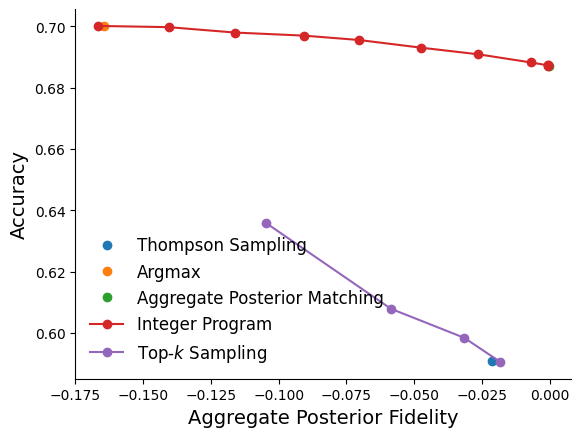

In [13]:
point_methods = ["Thompson Sampling", "Argmax", "Aggregate Posterior Matching"]
curve_methods = ["Integer Program", "Top-$\it k$ Sampling"]
plot_pareto(
    means,
    points=point_methods,
    curves=curve_methods,
    fid_col="Aggregate Posterior Fidelity",
    acc_col="Accuracy",
    filename=None,
)

## Information Curves

In [16]:
## Parameters


n_gammas = 11
gamma_range = (0.8, 1)

normal_x = True
normal_covs = [100, 2, 1, 0.5, 0.25, 0.0000000001]
indicator_strengths = [1 / 6, 2 / 6, 3 / 6, 4 / 6, 5 / 6, 1]

y_dist = YDist(prior)

if normal_x:
    x_dists = [
        NormalXDist(y_dist, np.eye(len(prior)), [normal_cov for _ in range(len(prior))])
        for normal_cov in normal_covs
    ]
    x_dist_labels = [f"variance={c}" for c in normal_covs]
else:
    x_dists = [
        CategoricalXDist(
            y_dist, generate_uniform_err_indicator(indicator_strength, len(prior))
        )
        for indicator_strength in indicator_strengths
    ]
    x_dist_labels = ["1/6", "2/6", "3/6", "4/6", "5/6", "1"]

info_param_colname = "information"

dist_type = "Normal" if normal_x else "Categorical"

gammas = np.round(np.linspace(*gamma_range, n_gammas, endpoint=True), 2)

expected_marginal = y_dist.expected_marginal(n_voters)

infocurve_predictions_dir = f"{predictions_dir}{dist_type}/infocurve/{dist_type}type_{n_voters}N_{gamma_range[0]}-{gamma_range[1]}-{n_gammas}gamma-{fidelity_metric}/"
os.makedirs(infocurve_predictions_dir, exist_ok=True)

In [19]:
def simulate_infocurve(
    n_voters: int,
    y_dist: YDist,
    x_dists: list[XDist],
    gammas,
    fidelity_metric,
    dists_labels=None,
    timeout=10,
):
    dists_labels = range(len(x_dists)) if dists_labels is None else dists_labels
    assert len(dists_labels) == len(x_dists)

    data, posteriors = generate_infocurve_data(
        n_voters, y_dist, x_dists, dists_labels=dists_labels
    )

    posterior_list = [posteriors[key] for key in dists_labels]
    reiterate = [
        (posterior, gamma, fidelity_metric, None, cp.GUROBI, timeout)
        for posterior in posterior_list
        for gamma in gammas
    ]
    with Pool() as p:
        all_preds = p.starmap(
            balance_objectives, reiterate, chunksize=1
        )  ## array shape (n_indicators*n_gammas, n_voters)

    with Pool(os.cpu_count() // 2) as p:
        max_weights = p.map(max_weight_discretization, posterior_list)

    all_preds = np.reshape(all_preds, (len(x_dists), len(gammas), n_voters))
    preds_by_dist = {
        label: pd.DataFrame(np.array([mweight, *preds]).T, columns=[0, *gammas])
        for label, mweight, preds in zip(dists_labels, max_weights, all_preds)
    }
    results_by_dist = {
        label: assess_predictions(
            preds,
            fidelity_metric,
            long_labels=data["y"],
            posterior=posterior,
            prior=y_dist.prior,
        )
        for (label, preds), posterior in zip(preds_by_dist.items(), posterior_list)
    }

    preds_by_dist = pd.concat(
        preds_by_dist, names=[info_param_colname, "index"], axis=1
    )
    results_by_dist = pd.concat(results_by_dist, names=[info_param_colname, "gamma"])
    posteriors["y"] = data["y"]

    return data, posteriors, preds_by_dist, results_by_dist

In [20]:
n_samples = 1


for i in range(n_samples):
    print(i)
    timestamp = datetime.datetime.now()
    data, posteriors, predictions, results = simulate_infocurve(
        n_voters,
        y_dist,
        x_dists,
        gammas,
        fidelity_metric,
        dists_labels=x_dist_labels,
        timeout=10,
    )
    data.to_csv(
        f"{infocurve_predictions_dir}data_{timestamp}.txt"
    )  ## (n_indicators, n_voters)
    posteriors.to_csv(
        f"{infocurve_predictions_dir}posteriors_{timestamp}.txt"
    )  ## (n_classes)
    predictions.to_csv(
        f"{infocurve_predictions_dir}predictions_{timestamp}.txt"
    )  ## (n_indicators, n_gammas, n_voters)
    results.to_csv(
        f"{infocurve_predictions_dir}results_{timestamp}.txt"
    )  ## (n_indicators, n_gammas)

0


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10
Academic license - for non-commercial use only - expires 2024-09-10


/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


max counts allocated per class 0    2487
1    1251
2     639
3     315
4     154
5     154
dtype: int64
max counts allocated per class max counts allocated per class 0    2498
1    1252
2     625
3     312
4     157
5     156
dtype: int64
0    2508
1    1232
2     630
3     316
4     158
5     156
dtype: int64
max counts allocated per class 0    2512
1    1221
2     632
3     314
4     164
5     157
dtype: int64
max counts allocated per class 0    2520
1    1252
2     610
3     308
4     158
5     152
dtype: int64
max counts allocated per class 0    2520
1    1237
2     615
3     321
4     162
5     145
dtype: int64


In [21]:
means = read_results(infocurve_predictions_dir, [info_param_colname, "gamma"])
accuracies = [x[1]["Accuracy"] for x in means.groupby(info_param_colname, sort=False)]
fidelities = [
    x[1]["Aggregate Posterior Fidelity"]
    for x in means.groupby(info_param_colname, sort=False)
]

n_samples 2


In [22]:
def plot_info_curves(accuracies, fidelities, labels, colors=None, filename=None):
    colors = [""] * len(accuracies) if colors is None else colors
    for acc, marg, param, color in zip(accuracies, fidelities, labels, colors):
        plt.plot(np.array(marg), np.array(acc), f"-o{color}", label=param)

    sns.despine()
    axlabel_size = 14

    plt.xlabel("Fidelity", fontsize=axlabel_size)
    plt.ylabel("Accuracy", fontsize=axlabel_size)
    tick_size = 10
    plt.tick_params(axis="both", which="major", rotation=0, labelsize=tick_size)

    plt.legend(title="Information", frameon=False, title_fontsize=14, fontsize=12)
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight", dpi=500)
    plt.show()

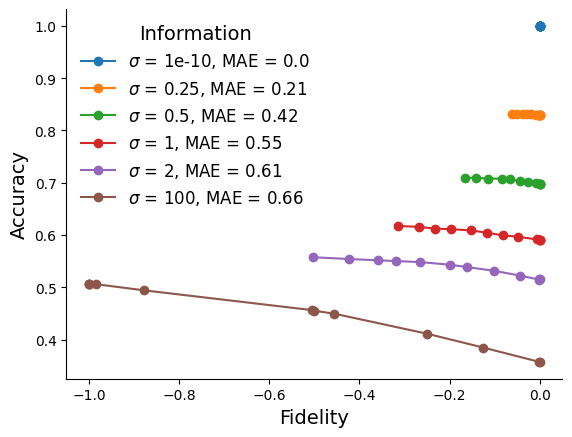

In [23]:
mae_samples = 100000
normal_maes = [mc_normal_mae(mae_samples, y_dist, x_dist) for x_dist in x_dists]
legendtext = [
    f"$\\sigma$ = {c}, MAE = {str(round(m, 2))}"
    for c, m in zip(normal_covs, normal_maes)
]

plot_info_curves(
    accuracies[::-1],
    fidelities[::-1],
    legendtext[::-1],
    filename=f"{plots_dir}information_curves.pdf",
)

## Argmax Bias by Information

In [30]:
## Parameters
normal_x = True
normal_covs = [100, 1, 0.25]
indicator_strengths = [1 / 6, 3 / 6, 5 / 6]

y_dist = YDist(prior)
n_classes = len(prior)

if normal_x:
    x_dists = [
        NormalXDist(y_dist, np.eye(len(prior)), [normal_cov for _ in range(len(prior))])
        for normal_cov in normal_covs
    ]
    x_dist_labels = [f"variance={c}" for c in normal_covs]
else:
    x_dists = [
        CategoricalXDist(
            y_dist, generate_uniform_err_indicator(indicator_strength, len(prior))
        )
        for indicator_strength in indicator_strengths
    ]
    x_dist_labels = [
        "1/6",
        "3/6",
        "5/6",
    ]

info_param_colname = "information"

dist_type = "Normal" if normal_x else "Categorical"

expected_marginal = y_dist.expected_marginal(n_voters)

In [31]:
def quick_barplot(df, xlabel="", ylabel="", colors=None, filename=None):
    g = sns.catplot(
        data=df.reset_index().melt(id_vars="Class"),
        kind="bar",
        x="Class",
        y="value",
        hue="variable",
        palette=colors,
    )
    g.despine()

    axlabel_size = 14
    tick_size = 10

    g.set_axis_labels(xlabel, ylabel, fontsize=axlabel_size)
    g.legend.set_title("Information")
    plt.setp(g.legend.get_texts(), fontsize=12)
    plt.setp(g.legend.get_title(), fontsize=14)
    sns.move_legend(g, loc="upper center")

    plt.tick_params(axis="both", which="major", rotation=10, labelsize=tick_size)

    if filename is not None:
        plt.savefig(filename, dpi=500, bbox_inches="tight")

/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vect

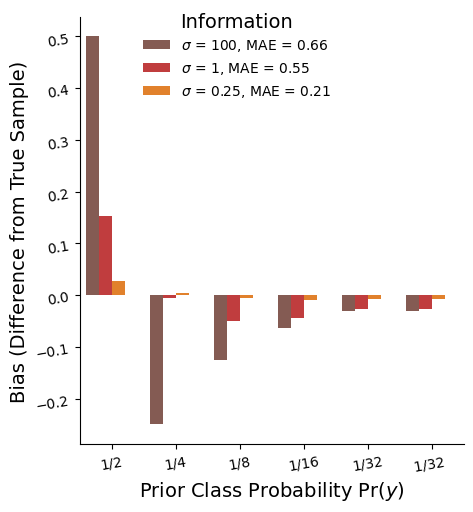

In [32]:
n_samples = 1000
samples = []
sample_diffs = []
for _ in range(n_samples):
    data, posteriors = generate_infocurve_data(
        n_voters, y_dist, x_dists, dists_labels=x_dist_labels
    )

    y_counts = np.bincount(data["y"], minlength=y_dist.n_classes)
    posteriors_list = [posteriors[key] for key in x_dist_labels]
    argmax_counts = [
        np.bincount(mode_discretization(posterior), minlength=y_dist.n_classes)
        for posterior in posteriors_list
    ]
    argmax_counts = np.array(argmax_counts)  ## (n_dists, n_classes)

    sampled_bias = (
        argmax_counts - y_counts[np.newaxis, :]
    )  ##(n_strengths, n_classes) - (1, n_classes)
    samples.append(sampled_bias)  ##(n_samples, n_strengths, n_classes)

sample_biases = np.mean(samples, axis=0)

prior_text = [
    "1/2",
    "1/4",
    "1/8",
    "1/16",
    "1/32",
    "1/32 ",
]


mae_samples = 100000
normal_maes = [mc_normal_mae(mae_samples, y_dist, x_dist) for x_dist in x_dists]
legendtext = [
    f"$\\sigma$ = {c}, MAE = {str(round(m, 2))}"
    for c, m in zip(normal_covs, normal_maes)
]

sample_biases = pd.DataFrame(
    sample_biases.T, columns=legendtext, index=pd.Index(prior_text, name="Class")
)

sample_biases["_filler"] = 0  ## for spacing
colors = sns.color_palette().as_hex()[5:0:-2]

quick_barplot(
    sample_biases / n_voters,
    xlabel="Prior Class Probability Pr($\it y$)",
    ylabel="Bias (Difference from True Sample)",
    colors=colors,
)  # filename=f"{plots_dir}infobiases.pdf")

## Proof Check

In [36]:
## PARAMS
fidelity_metric = "L1"
timeout = 10  ## seconds
plots_dir = "outputs/synthetic/"

In [37]:
### DATA GENERATION


def generate_true_labels(n, class_proportions):
    label_counts = np.random.multinomial(n, class_proportions)
    return label_counts


def generate_categorical_x(label_counts, feature_dist):
    """
    Args:
        label_counts (list[int]): n_classes length list of the number of times each class appears
        feature dist (ndarray): n_classes x n_categories ndarray of x|y probabilities, for categorical feature of finite values
    """
    x_data = []

    for n, weights in zip(label_counts, feature_dist):
        ## generate n rows of x
        xs_given_ys = np.random.choice(len(weights), size=n, p=weights)
        x_data.append(xs_given_ys)
    x_data = np.concatenate(x_data)
    return x_data


## one
def generate_uniform_err_indicator(plurality_prob, n_classes):
    ## indicates the corresponding class with probability p. Otherwise, choose one of the other classes
    even_rest = (1 - plurality_prob) / (n_classes - 1)
    feat_probs = np.eye(n_classes) * (plurality_prob - even_rest) + even_rest
    return feat_probs


def generate_worst_case_sample(n, x_freqs):
    n_classes = len(x_freqs) - 1  ## one category per class... plus the extra one??
    x_counts = generate_true_labels(
        n, x_freqs
    )  ## x_freqs essentially corresponds to S_a/c/e. let the last be extra
    perfect_probs = np.eye(len(x_freqs), n_classes)  ## n_categories, n_classes
    perfect_probs[-1, :] = 1 / n_classes
    ys = generate_categorical_x(x_counts, perfect_probs)

    xs = np.repeat(np.arange(len(x_freqs)), x_counts)
    posterior = perfect_probs[xs]

    return ys, posterior


def worst_case_mae(x_freqs):
    n_classes = len(x_freqs) - 1  ## one category per class, plus the extra one
    perfect_probs = np.eye(len(x_freqs), n_classes)  ## n_categories, n_classes
    perfect_probs[-1, :] = 1 / n_classes

    joint_probs = (
        np.array(x_freqs)[:, np.newaxis] * perfect_probs
    )  ## n_categories, n_classe
    abs_errors = 1 - perfect_probs  ## n_categories, n_classes
    weighted_errors = abs_errors * joint_probs
    mae = np.sum(weighted_errors)
    return mae


def distribution_bayes_optimal(prior, px_given_y):
    """ "
    prior is (n_classes)
    px|y is (n_classes, n_categories), I believe?
    """
    ## categories are generally square here
    pxy = np.array(prior)[:, np.newaxis] * np.array(
        px_given_y
    )  ## (n_classes, n_categories)
    px = np.sum(pxy, axis=0)  # n_categories
    py_given_x = (pxy / px[np.newaxis, :]).T  # (n_categories, n_classes)

    return py_given_x


def generate_bayesian_data(n_samples, prior, indicator_strength):
    assert np.isclose(np.sum(prior), 1), np.sum(prior)
    ## generate a sample of y
    sim_label_counts = generate_true_labels(n_samples, prior)
    labels = np.repeat(np.arange(len(prior)), sim_label_counts)
    ## calculate p(x|y)
    feat_probs = generate_uniform_err_indicator(indicator_strength, len(prior))
    ## generate a sample of x
    x_data = generate_categorical_x(sim_label_counts, feat_probs)
    ## calculate p(y|x)
    expected_posteriors = distribution_bayes_optimal(prior, feat_probs)

    posterior = expected_posteriors[x_data]
    assert np.isclose(posterior.sum(axis=1), 1).all()
    return labels, posterior


def analytic_mae(prior, feat_probs, posterior):
    """
    n_classes is size of Y, n_categories is size of (discrete) X
    prior is (n_classes) array, being p(y)
    for conditional probabilities, the first dimension is condition, second is the actual variable
    feat_probs is (n_classes, n_categories), being p(x|y)
    posterior is (n_categories, n_classes), being p(y|x)
    """
    joint_probs = np.array(prior)[:, np.newaxis] * np.array(
        feat_probs
    )  ## (n_classes, n_categories)
    print("p(x, y)", joint_probs)
    abs_errors = 1 - posterior  ## n_categories, n_classes
    weighted_errors = abs_errors.T * joint_probs
    print("weighted errors", weighted_errors)
    mae = np.sum(weighted_errors)
    return mae


def bayes_mae(prior, feat_probs):
    ## calculate p(y|x)
    expected_posteriors = distribution_bayes_optimal(prior, feat_probs)
    return analytic_mae(prior, feat_probs, expected_posteriors)


def generate_x_freqs(a, c, n_classes):
    e = (1 - sum([a, c])) / (n_classes - 1)
    x_freqs = [a] + [e] * (n_classes - 1) + [c]
    return np.array(x_freqs)

/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edong/Documents/code/research/posterior_discretization/posterior_discretization/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vect

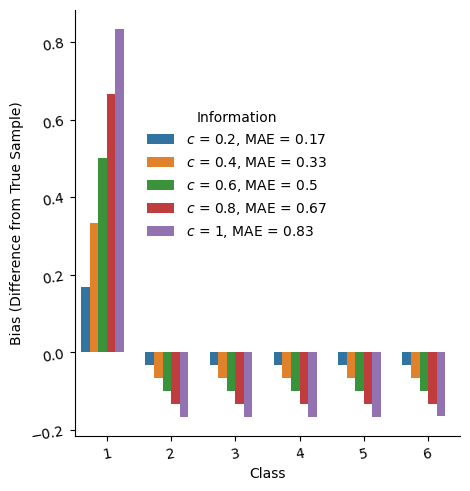

In [38]:
predictions = np.argmax(posterior, axis=1)


def quick_barplot(df, xlabel="", ylabel="", filename=None):
    g = sns.catplot(
        data=df.reset_index().melt(id_vars="Class"),
        kind="bar",
        x="Class",
        y="value",
        hue="variable",
    )
    g.despine()

    g.set_axis_labels("Class", "Bias (Difference from True Sample)")
    g.legend.set_title("Information")
    sns.move_legend(g, loc=(0.3, 0.5))

    plt.tick_params(axis="both", which="major", rotation=10)

    if filename is not None:
        plt.savefig(filename, dpi=500, bbox_inches="tight")


n_samples = 100

c_vals = [0.2, 0.4, 0.6, 0.8, 1]
frequencies = [generate_x_freqs(1 - c, c, n_classes) for c in c_vals]
maes = [worst_case_mae(freqs) for freqs in frequencies]

samples = []
for x_freqs in frequencies:
    freq_samples = []
    for _ in range(n_samples):
        labels, posterior = generate_worst_case_sample(n_voters, x_freqs)
        argmax_counts = np.bincount(
            mode_discretization(posterior), minlength=posterior.shape[1]
        )

        sampled_bias = argmax_counts - np.bincount(labels, minlength=n_classes)
        freq_samples.append(sampled_bias)  ##(n_samples, n_classes)
    samples.append(freq_samples)

sample_biases = np.mean(samples, axis=1)  ## n_freqs, n_classes

col_texts = [f"$\it c$ = {c}, MAE = {mae}" for c, mae in zip(c_vals, np.round(maes, 2))]

sample_biases = pd.DataFrame(
    sample_biases.T,
    columns=col_texts,
    index=pd.Index(range(1, n_classes + 1), name="Class"),
)
sample_biases["_filler"] = 0
quick_barplot(
    sample_biases / n_voters,
    xlabel="",
    ylabel="Bias (Difference from True Sample)",
    filename=f"{plots_dir}worst_biases.pdf",
)